In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, accuracy_score,  classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import preprocessing
import ipaddress

import warnings
warnings.simplefilter('ignore')

## Data preprocessing

In [3]:
#DATADIR = '/home/infres/abiapo/prim/data'
DATADIR = '/home/infres/sagbo-21/Documents/PRIM/PRIM/data'

In [4]:
data = pd.read_csv(DATADIR+'/unbalance_mix_data_40_60.csv')
data.head()

,Unnamed:_0,Flow_ID,Source_IP,Source_Port,Destination_IP,Destination_Port,Protocol,Timestamp,Flow_Duration,Total_Fwd_Packets,...,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,SimillarHTTP,Inbound,Label,label
0,63090,172.16.0.5-192.168.50.1-53886-52313-17,172.16.0.5,53886,192.168.50.1,52313,17,2018-12-01 12:55:39.691985,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,DrDoS_UDP,1
1,331646,172.16.0.5-192.168.50.4-8761-40089-6,172.16.0.5,8761,192.168.50.4,40089,6,2018-11-03 11:29:59.315895,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,Syn,1
2,23868,172.16.0.5-192.168.50.1-62707-26320-17,172.16.0.5,62707,192.168.50.1,26320,17,2018-12-01 13:53:58.779233,6004043,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,TFTP,1
3,47275,172.16.0.5-192.168.50.1-62519-8952-17,172.16.0.5,62519,192.168.50.1,8952,17,2018-12-01 13:56:35.445012,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,TFTP,1
4,115481,172.16.0.5-192.168.50.1-62543-55990-17,172.16.0.5,62543,192.168.50.1,55990,17,2018-12-01 13:45:14.614697,3001833,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,TFTP,1


In [5]:
data = data.drop(['Unnamed:_0'],axis=1)
data['Source_IP'] = data['Source_IP'].apply(lambda ip: int(ipaddress.ip_address(ip)))
data['Destination_IP'] = data['Destination_IP'].apply(lambda ip: int(ipaddress.ip_address(ip)))
data = data.drop(['Flow_ID'],axis=1)
data = data.drop(['Timestamp'],axis=1)
data = data.drop(['SimillarHTTP'],axis=1)

In [6]:
data = data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]

In [7]:
X = data.iloc[:,:-2]
y = data.iloc[:,-1].to_numpy()

In [8]:
principal_feature = ['Inbound', 'URG_Flag_Count', 'Min_Packet_Length', 'Destination_IP', 
                     'CWE_Flag_Count', 'Destination_Port', 'Protocol', 'Avg_Fwd_Segment_Size', 
                     'Average_Packet_Size', 'Flow_Packets_s', 'Fwd_Packets_s', 'Fwd_Packet_Length_Mean', 
                     'Flow_Bytes_s', 'Fwd_PSH_Flags', 'Packet_Length_Mean', 'Fwd_Packet_Length_Min', 
                     'Down_Up_Ratio', 'RST_Flag_Count', 'Fwd_Packet_Length_Max', 'Init_Win_bytes_forward']

In [9]:
X = X[principal_feature]

## Models

In [10]:
def cal_accuracy(y_test, y_pred): 
    print("Confusion Matrix: ")
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    print ("Accuracy : ", accuracy_score(y_test,y_pred)*100) 
    print("Report : ", classification_report(y_test, y_pred))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)   

In [12]:
std_scaler = StandardScaler()
std_scaler.fit(X_train)
X_train = std_scaler.transform(X_train)
X_test = std_scaler.transform(X_test)

#### Decision Tree

Confusion Matrix: 
Accuracy :  99.98755739153155
Report :                precision    recall  f1-score   support

           0       1.00      1.00      1.00     32546
           1       1.00      1.00      1.00     47823

    accuracy                           1.00     80369
   macro avg       1.00      1.00      1.00     80369
weighted avg       1.00      1.00      1.00     80369



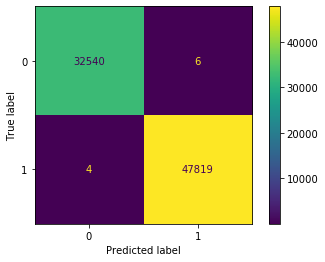

In [13]:
from sklearn.tree import DecisionTreeClassifier 
clf_entropy = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
clf_entropy.fit(X_train, y_train) 
y_pred_entropy = clf_entropy.predict(X_test)
cal_accuracy(y_test, y_pred_entropy)

#### Naive Bayes

Confusion Matrix: 
Accuracy :  98.20950864139158
Report :                precision    recall  f1-score   support

           0       0.96      0.99      0.98     32546
           1       1.00      0.97      0.98     47823

    accuracy                           0.98     80369
   macro avg       0.98      0.98      0.98     80369
weighted avg       0.98      0.98      0.98     80369



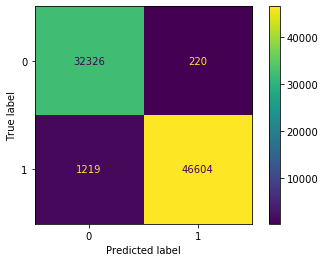

In [14]:
from sklearn.naive_bayes import GaussianNB 
gnb = GaussianNB() 
gnb.fit(X_train, y_train) 
y_pred_nb = gnb.predict(X_test)
cal_accuracy(y_test, y_pred_nb)

In [15]:
pred_prob_dt = clf_entropy.predict_proba(X_test)
pred_prob_nb = gnb.predict_proba(X_test)

# roc curve for models
fpr_dt, tpr_dt, thresh_dt = roc_curve(y_test, pred_prob_dt[:,1], pos_label=1)
fpr_nb, tpr_nb, thresh_nb = roc_curve(y_test, pred_prob_nb[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)


# auc scores
auc_score_dt = roc_auc_score(y_test, pred_prob_dt[:,1])
auc_score_nb = roc_auc_score(y_test, pred_prob_nb[:,1])

print(auc_score_dt, auc_score_nb)

0.9998660018927541 0.9991265355085656


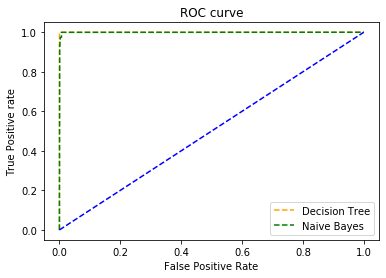

In [16]:
# plot roc curves
plt.plot(fpr_dt, tpr_dt, linestyle='--',color='orange', label='Decision Tree')
plt.plot(fpr_nb, tpr_nb, linestyle='--',color='green', label='Naive Bayes')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.show();

#### Logistic Regression

Confusion Matrix: 
Accuracy :  99.7337281787754
Report :                precision    recall  f1-score   support

           0       1.00      0.99      1.00     32546
           1       1.00      1.00      1.00     47823

    accuracy                           1.00     80369
   macro avg       1.00      1.00      1.00     80369
weighted avg       1.00      1.00      1.00     80369



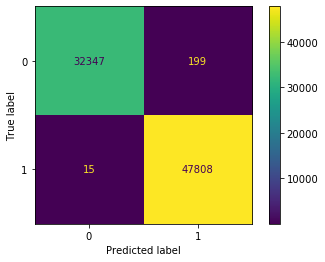

In [17]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='lbfgs', random_state = 0)
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)
cal_accuracy(y_test, y_pred_lr)

#### Support Vector Machine with gaussian kernel

Confusion Matrix: 
Accuracy :  99.97760330475681
Report :                precision    recall  f1-score   support

           0       1.00      1.00      1.00     32546
           1       1.00      1.00      1.00     47823

    accuracy                           1.00     80369
   macro avg       1.00      1.00      1.00     80369
weighted avg       1.00      1.00      1.00     80369



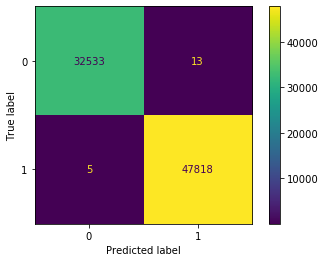

In [18]:
from sklearn.svm import SVC
clf_svm = SVC(kernel = 'rbf', random_state = 0,C=10.0, gamma=0.1,probability= True)
clf_svm.fit(X_train, y_train)
y_pred_svc = clf_svm.predict(X_test)
cal_accuracy(y_test, y_pred_svc)

In [19]:
pred_prob_logreg = logreg.predict_proba(X_test)
pred_prob_svm = clf_svm.predict_proba(X_test)

# roc curve for models
fpr_logreg, tpr_logreg, thresh_logreg = roc_curve(y_test, pred_prob_logreg[:,1], pos_label=1)
fpr_svm, tpr_svm, thresh_svm = roc_curve(y_test, pred_prob_svm[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)


# auc scores
auc_score_logreg = roc_auc_score(y_test, pred_prob_logreg[:,1])
auc_score_svm = roc_auc_score(y_test, pred_prob_svm[:,1])

print(auc_score_logreg, auc_score_svm)

0.9997474620661086 0.9999410079630846


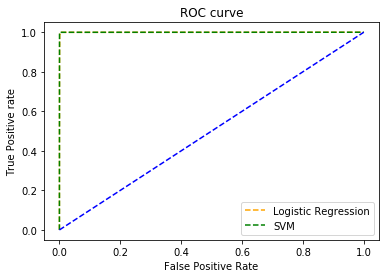

In [20]:
# plot roc curves
plt.plot(fpr_logreg, tpr_logreg, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(fpr_svm, tpr_svm, linestyle='--',color='green', label='SVM')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.show();

#### K Nearest Neighbor

Confusion Matrix: 
Accuracy :  99.9800918264505
Report :                precision    recall  f1-score   support

           0       1.00      1.00      1.00     32546
           1       1.00      1.00      1.00     47823

    accuracy                           1.00     80369
   macro avg       1.00      1.00      1.00     80369
weighted avg       1.00      1.00      1.00     80369



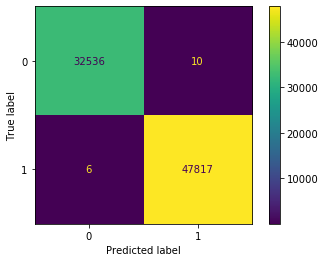

In [21]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
cal_accuracy(y_test, y_pred_knn)

#### Random Forest

Confusion Matrix: 
Accuracy :  99.99004591322525
Report :                precision    recall  f1-score   support

           0       1.00      1.00      1.00     32546
           1       1.00      1.00      1.00     47823

    accuracy                           1.00     80369
   macro avg       1.00      1.00      1.00     80369
weighted avg       1.00      1.00      1.00     80369



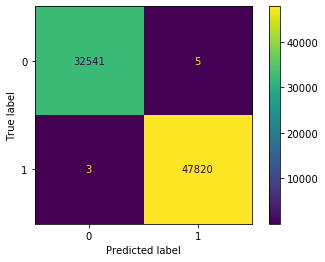

In [22]:
from sklearn.ensemble import RandomForestClassifier
rndForest =RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)
rndForest.fit(X_train,y_train)
y_pred_rf = rndForest.predict(X_test)
cal_accuracy(y_test, y_pred_rf)

In [23]:
pred_prob_knn = knn.predict_proba(X_test)
pred_prob_rf = rndForest.predict_proba(X_test)

# roc curve for models
fpr_knn, tpr_knn, thresh_knn = roc_curve(y_test, pred_prob_knn[:,1], pos_label=1)
fpr_rf, tpr_rf, thresh_rf = roc_curve(y_test, pred_prob_rf[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)


# auc scores
auc_score_knn = roc_auc_score(y_test, pred_prob_knn[:,1])
auc_score_rf = roc_auc_score(y_test, pred_prob_rf[:,1])

print(auc_score_knn, auc_score_rf)

0.9998966701320329 0.9999845362582446


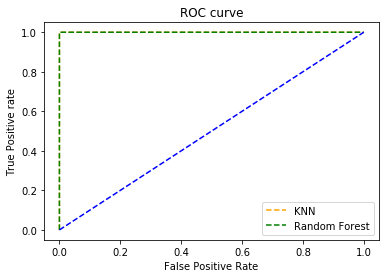

In [24]:
# plot roc curves
plt.plot(fpr_knn, tpr_knn, linestyle='--',color='orange', label='KNN')
plt.plot(fpr_rf, tpr_rf, linestyle='--',color='green', label='Random Forest')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.show();

 #### LightGBM

Confusion Matrix: 
Accuracy :  99.99377869576578
Report :                precision    recall  f1-score   support

           0       1.00      1.00      1.00     32546
           1       1.00      1.00      1.00     47823

    accuracy                           1.00     80369
   macro avg       1.00      1.00      1.00     80369
weighted avg       1.00      1.00      1.00     80369



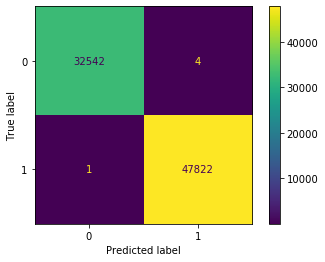

In [25]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier()
lgb.fit(X_train, y_train)
y_pred_lgb = lgb.predict(X_test)
cal_accuracy(y_test, y_pred_lgb)

In [26]:
print('Training set score: {:.4f}'.format(lgb.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(lgb.score(X_test, y_test)))

Training set score: 1.0000
Test set score: 0.9999


#### XGBoost

Confusion Matrix: 
Accuracy :  99.99253443491894
Report :                precision    recall  f1-score   support

           0       1.00      1.00      1.00     32546
           1       1.00      1.00      1.00     47823

    accuracy                           1.00     80369
   macro avg       1.00      1.00      1.00     80369
weighted avg       1.00      1.00      1.00     80369



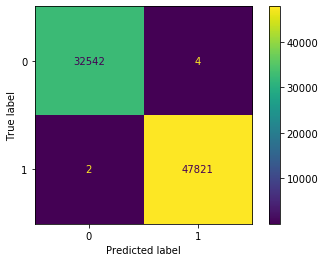

In [27]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
cal_accuracy(y_test, y_pred_xgb)

In [28]:
print('Training set score: {:.4f}'.format(xgb.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(xgb.score(X_test, y_test)))

Training set score: 1.0000
Test set score: 0.9999


In [29]:
pred_prob_xgb = xgb.predict_proba(X_test)
pred_prob_lgb = lgb.predict_proba(X_test)

# roc curve for models
fpr_xgb, tpr_xgb, thresh_xgb = roc_curve(y_test, pred_prob_xgb[:,1], pos_label=1)
fpr_lgb, tpr_lgb, thresh_lgb = roc_curve(y_test, pred_prob_lgb[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)


# auc scores
auc_score_xgb = roc_auc_score(y_test, pred_prob_xgb[:,1])
auc_score_lgb = roc_auc_score(y_test, pred_prob_lgb[:,1])

print(auc_score_xgb, auc_score_lgb)

0.9999972919096953 0.9999489998813051


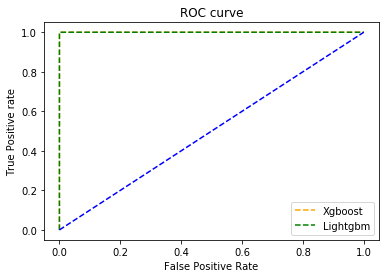

In [30]:
# plot roc curves
plt.plot(fpr_xgb, tpr_xgb, linestyle='--',color='orange', label='Xgboost')
plt.plot(fpr_lgb, tpr_lgb, linestyle='--',color='green', label='Lightgbm')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.show();

#### Multi Layer Perceptron

Confusion Matrix: 
Accuracy :  99.9825803481442
Report :                precision    recall  f1-score   support

           0       1.00      1.00      1.00     32546
           1       1.00      1.00      1.00     47823

    accuracy                           1.00     80369
   macro avg       1.00      1.00      1.00     80369
weighted avg       1.00      1.00      1.00     80369



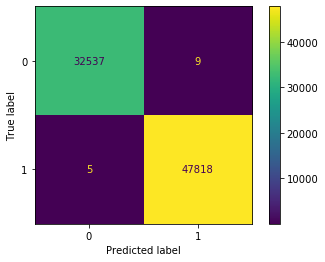

In [31]:
from sklearn.neural_network import MLPClassifier
mlp_clf = MLPClassifier(hidden_layer_sizes=(150,100),
                        max_iter = 300,activation = 'relu',
                        solver = 'adam')
mlp_clf.fit(X_train, y_train)
y_pred_mlp = mlp_clf.predict(X_test)
cal_accuracy(y_test, y_pred_mlp)

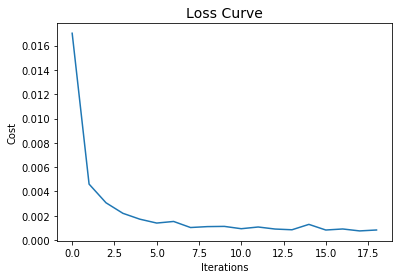

In [32]:
plt.plot(mlp_clf.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

In [33]:
print('Training set score: {:.4f}'.format(mlp_clf.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(mlp_clf.score(X_test, y_test)))

Training set score: 0.9999
Test set score: 0.9998


In [34]:
pred_prob_mlp = mlp_clf.predict_proba(X_test)

# roc curve for models
fpr_mlp, tpr_mlp, thresh_mlp = roc_curve(y_test, pred_prob_mlp[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)


# auc scores
auc_score_mlp = roc_auc_score(y_test, pred_prob_mlp[:,1])

print(auc_score_mlp)

0.9999794769801653


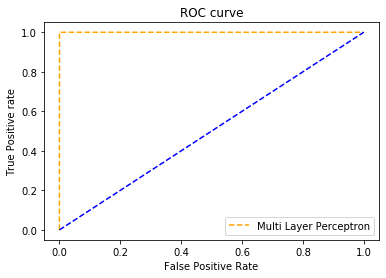

In [35]:
# plot roc curves
plt.plot(fpr_mlp, tpr_mlp, linestyle='--',color='orange', label='Multi Layer Perceptron')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.show();